In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score,balanced_accuracy_score
from sklearn.decomposition import PCA

import umap

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#! pip install umap-learn

In [3]:
np.random.seed(51)

#### Display options

In [4]:
pd.set_option('display.max_row', 25)
pd.set_option('display.max_column', 25)

##### Load the embeddings representations for the ACCP (which is the training dataset) and the HCP dataset (which will be the input for the trained SVM classifier)

In [5]:
embeddings_ACCP= pd.read_csv("/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Output/2024-05-13/09-33-29_206/acc_epoch60_embeddings/full_embeddings.csv")#, index_col=0)
#embeddings_ACCP= pd.read_csv("/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Output/2024-05-17/17-33-50_137/ACCP_epoch60_embeddings/full_embeddings.csv")
print(embeddings_ACCP.head())
embeddings_ACCP.shape

             ID       dim1       dim2       dim3       dim4       dim5  \
0  1-03HUBJO_t0 -10.300048  -8.993956 -24.014177 -22.748718 -20.079226   
1  1-08ANDTI_t0  17.782938 -21.937262 -25.368660   5.567630 -42.060616   
2  1-11LEBJO_t0 -36.685577   5.157880   2.363987 -22.430391 -11.315966   
3  1-15LEHMI_t0 -16.128769  14.951199 -14.732849   5.576864 -21.033754   
4  1-17COLMA_t0 -12.741240 -20.531580  -7.063102  15.749422 -26.560053   

        dim6       dim7       dim8       dim9      dim10      dim11  ...  \
0  10.081562 -35.838430  -5.443741  -0.482752  11.556986  -8.657738  ...   
1  16.843365  12.600588 -10.436407   5.698798   8.553762 -15.713575  ...   
2  13.808375 -49.053246  22.700457  -8.459773  12.038797  10.005174  ...   
3 -10.399233 -45.814720 -26.131533 -27.402475  28.106800 -20.567886  ...   
4   2.146704 -26.149153   9.108587 -27.432632  32.134678  -5.934505  ...   

      dim245     dim246     dim247     dim248     dim249     dim250  \
0   7.355058   1.090255 -45

(341, 257)

In [6]:
labels_ACCP = pd.read_csv("/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/subjects_labels.csv")
labels_ACCP[['PCS3_L0', 'PCS3_L1', 'PCS3_R0', 'PCS3_R1']].head()
labels_ACCP.columns

Index(['Unnamed: 0', 'PERSON_ID', 'Sujet', 'name', 'DATABASE', 'SEX', 'HAND',
       'IRM_NAME0', 'IRM_NAME1', 'long_name', 'Left_PCS', 'Right_PCS',
       'AGESCAN0', 'AGESCAN1', 'Age', 'Groupe', 'GroupeNew', 'QC_Cloelia0',
       'QC_Cloelia1', 'PCS_L0', 'PCS_L1', 'PCS_L_num3_0', 'PCS_L_num3_1',
       'PCS_L_num1_0', 'PCS_L_num1_1', 'JUDGMENT (L)0', 'JUDGMENT (L)1',
       'PCS_R0', 'PCS_R1', 'PCS_R_num3_0', 'PCS_R_num3_1', 'PCS_R_num1_0',
       'PCS_R_num1_1', 'JUDGMENT (R)0', 'JUDGMENT (R)1', 'DURATION_FOLLOWUP',
       'PCS3_L0', 'PCS3_L1', 'PCS3_R0', 'PCS3_R1', 'PCS2_L0', 'PCS2_L1',
       'PCS2_R0', 'PCS2_R1', 'Stroop', 'Unnamed: 8', 'LQC', 'RQC', 'Asym2',
       'Asym3', 'StroopLecture', 'StroopCouleur', 'StroopIncong',
       'Incong-lecture', 'Inc-coul', 'TMTA', 'TMTB', 'Flex', 'right_3level',
       'left_2level', 'right_2level', 'Asym3_from2', 'Asym3_from3',
       'Asym2_from2', 'PCS_asymetry'],
      dtype='object')

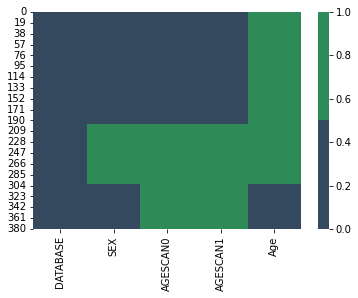

/usr/lib/python3/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,AGESCAN0,AGESCAN1,Age
count,197.000000,197.000000,80.000000
mean,14.023401,20.293503,18.837945
std,3.540376,4.862891,8.046617
min,6.540000,10.380000,9.460274
25%,11.630000,16.740000,11.810274
50%,13.630000,20.100000,17.405479
75%,15.790000,23.960000,25.228082
max,26.420000,32.800000,40.473973


In [25]:
dcfro = labels_ACCP[['DATABASE', 'SEX', 'AGESCAN0', 'AGESCAN1','Age']]
colours = ['#34495E', 'seagreen'] 
sns.heatmap(dcfro.isnull(), cmap=sns.color_palette(colours))
plt.show()
dcfro.AGESCAN0 = dcfro.AGESCAN0.str.replace(',', '.').astype('float')
dcfro.AGESCAN1 = dcfro.AGESCAN1.str.replace(',', '.').astype('float')
dcfro.describe()

In [7]:
labels_ACCP = labels_ACCP[['long_name','Left_PCS']]

In [8]:
def encoder(df, col):
    code = {'present':1,
            'absent':0}
    df[col] = df[col].map(code)
    return df

encoder(labels_ACCP,'Left_PCS') 

,long_name,Left_PCS
0,nih_chp_04701_t1,1
1,nih_chp_01534_t1,1
2,nih_chp_04623_t1,1
3,nih_chp_01503_t1,0
4,nih_chp_00404_t1,1
...,...,...
376,a0005_t1_s03,0
377,a0006_t1_s03,1
378,a0001_t1_s03,1
379,a0016_t1_s03,0


In [9]:
embeddings_HCP = pd.read_csv("/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Output/2024-05-13/09-33-29_206/hcp_epoch60_embeddings/full_embeddings.csv", index_col=0)
#embeddings_HCP = pd.read_csv("/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Output/2024-05-17/17-33-50_137/HCP_epoch60_embeddings/full_embeddings.csv", index_col=0)
embeddings_HCP.head()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,...,dim245,dim246,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,,,,,
100206,-5.876003,-0.845744,-12.204170,10.151408,-18.957836,-29.795780,12.937123,-7.214358,15.110987,10.792451,-7.787244,9.263735,...,7.441906,6.935698,-15.116919,33.840183,-19.154482,12.863470,-20.392763,-25.990793,4.171558,-21.955696,-0.573337,-4.697568
100307,-19.529308,-7.768003,-16.622694,15.692203,-32.981106,-20.219995,-20.074820,3.648118,4.962884,28.067015,7.735142,13.419550,...,8.451640,-9.411729,-2.882752,35.724358,-11.517761,25.840712,-23.715145,-31.383976,7.298614,-4.549547,22.780191,-29.140709
100408,-24.607979,2.905064,-9.724290,35.772090,-38.557724,5.821410,-11.363668,18.840570,-9.526131,34.880870,-6.178275,-7.339914,...,11.223726,6.418972,5.701094,47.347880,-1.811345,-25.851000,2.173108,10.323122,-16.164135,32.424270,-1.851322,15.037244
100610,-8.027011,0.322856,-15.113009,3.927100,-22.753002,-6.738647,10.846553,47.801365,18.840824,19.917740,-4.696721,-15.373317,...,-10.238463,13.516448,-4.859896,60.652016,10.704345,-9.717216,-4.234411,-0.872676,-14.263339,-9.549306,8.477722,4.729099
101006,-25.976790,-5.441645,-10.610805,-9.526792,14.037749,-4.063296,12.062643,-15.676752,12.239485,5.389635,8.132303,-29.955600,...,-26.664420,20.419096,-7.835833,56.926426,6.239031,-7.533917,2.079582,8.960461,12.988546,-5.051035,25.262693,-14.783053


#### Load the UKBiobank embedded space to fit the scaler for the ACCP and HCP data 

In [10]:
embeddings_UKB = pd.read_csv("/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Output/2024-05-13/09-33-29_206/UKB_epoch60_embeddings/full_embeddings.csv", index_col=0)
#embeddings_UKB = pd.read_csv("/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Output/2024-05-17/17-33-50_137/UKB_epoch60_embeddings/full_embeddings.csv", index_col=0)
embeddings_UKB.head()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,...,dim245,dim246,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,,,,,
sub-1000021,3.411522,-3.809216,15.403873,9.348969,0.192424,-0.495174,-10.625201,21.913597,15.799512,-3.020029,-1.599291,24.007900,...,-3.597101,9.966516,4.427488,62.633220,11.167557,-12.174602,10.930779,-31.395472,-20.459242,4.932469,-7.491192,-0.486337
sub-1000458,-47.314980,-16.875847,6.268302,-14.805659,-3.636524,-15.009971,-25.361504,20.222443,10.710242,-7.875286,0.939618,-6.126307,...,2.333256,11.600016,-5.788480,20.703340,20.576696,-21.549343,25.276800,-30.138172,-13.101314,4.573277,7.830180,-26.364020
sub-1000575,-20.057571,-0.517332,11.068587,27.307678,-15.650618,-12.777596,22.677881,5.150224,33.190590,-19.315678,-10.560507,-1.558912,...,28.406765,31.836414,24.144289,30.855265,-0.058306,-10.811748,19.109825,-10.972364,-2.826630,-33.128902,-15.561665,-15.827283
sub-1000606,-38.277920,4.732678,12.894776,-9.342887,-0.053353,-22.454464,7.657977,-4.370313,12.114909,-5.552540,-24.740152,-12.155127,...,-24.432425,24.778074,-17.152739,47.780556,12.951429,0.663262,-11.146820,-12.129980,12.698999,0.334200,29.254696,-1.875374
sub-1000963,-3.616922,-4.445605,-14.435362,-35.122530,8.104991,-0.341337,-19.555150,-27.789082,-8.176664,23.098358,-3.846197,15.072195,...,0.244025,5.105164,-37.479347,25.962180,-5.279437,-14.123582,8.515189,-30.010107,9.012834,-1.461584,-14.874557,-4.218939


#### Scaler

In [11]:
ebdd_lbl_ACCP = embeddings_ACCP.set_index('ID').join(labels_ACCP.set_index('long_name'))
X = ebdd_lbl_ACCP.drop('Left_PCS', axis=1)
y = ebdd_lbl_ACCP['Left_PCS']

The scaler is fited on the ACCP database at first, it transforms it and then transforms the HCP dataset.
Is it better to fit on everything and transform everything at once ?

In [12]:
scaler = StandardScaler()
scaler.fit(embeddings_UKB)
X = scaler.transform(X)
scl_bdd_hcp = scaler.transform(embeddings_HCP)
scl_bdd_ukb = scaler.transform(embeddings_UKB)
X.shape ,scl_bdd_hcp.shape

((341, 256), (1114, 256))

#### Principal component Analysis

In [12]:
n_components=20

pca = PCA(n_components=n_components)
pca.fit(scl_bdd_hcp)
print(pca.explained_variance_ratio_)

[0.09859341 0.09229685 0.08913396 0.08015963 0.07205523 0.06738924
 0.06362197 0.05633425 0.05468394 0.05043517 0.04336356 0.04227925
 0.0361734  0.02964922 0.02733921 0.02197985 0.0186741  0.01533438
 0.01140069 0.00662035]


In [13]:
(np.cumsum(pca.explained_variance_ratio_) < 0.99).sum()

20

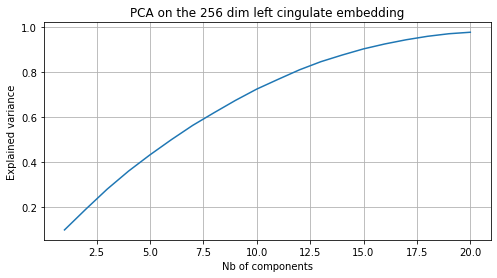

In [14]:
plt.figure(figsize=(8,4))
plt.plot(range(1,n_components+1,1), np.cumsum(pca.explained_variance_ratio_))
plt.grid(visible=True)
plt.xlabel('Nb of components')
plt.ylabel('Explained variance')
plt.title('PCA on the 256 dim left cingulate embedding')
plt.show()

<AxesSubplot:>

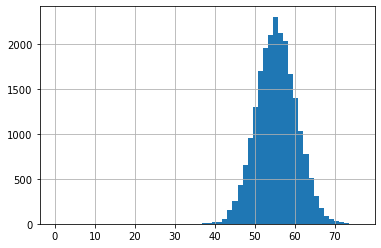

In [15]:
PCA_HCP = pca.transform(scl_bdd_hcp)
PCA_UKB = pca.transform(scl_bdd_ukb)

PCA_HCP = pd.DataFrame(PCA_HCP, columns=[f'Component_{i}' for i in range(n_components)])
PCA_UKB = pd.DataFrame(PCA_UKB, columns=[f'Component_{i}' for i in range(n_components)])

PCA_HCP['Dataset'] = 'hcp'
PCA_UKB['Dataset'] = 'UkBioBank'

PCA_HCP['ID'] = embeddings_HCP.index
PCA_UKB['ID'] = embeddings_UKB.index

PCA_All = pd.concat([PCA_UKB,PCA_HCP], axis=0)

# Calculate the centroid
centroid_values = PCA_All[[f'Component_{i}' for i in range(n_components)]].mean()

# Convert the centroid to a DataFrame
centroid = pd.DataFrame([centroid_values])
centroid['Dataset'] = 'centroid'
centroid['ID'] = 'centroid'

# Append the centroid row to the dataframe
PCA_All = pd.concat([PCA_All, centroid], axis=0, ignore_index=True)

# Function to calculate Manhattan distance to centroid
def calculate_manhattan_distance(row, centroid):
    return sum(abs(row[f'Component_{i}'] - centroid[f'Component_{i}']) for i in range(n_components))

# Calculate Manhattan distance for each point and add as a new column
PCA_All['Manhattan_Dist_to_Centroid'] = PCA_All.apply(
    lambda row: calculate_manhattan_distance(row, centroid_values) if row['ID'] != 'centroid' else 0,
    axis=1
)

PCA_All["Manhattan_Dist_to_Centroid"].hist(bins=60)

          IID  Manhattan_Dist_to_Centroid
21051  100206                   56.928875
21052  100307                   53.946410
21053  100408                   55.889243
21054  100610                   52.153470
21055  101006                   54.580351


array([[<AxesSubplot:title={'center':'Manhattan_Dist_to_Centroid'}>]],
      dtype=object)

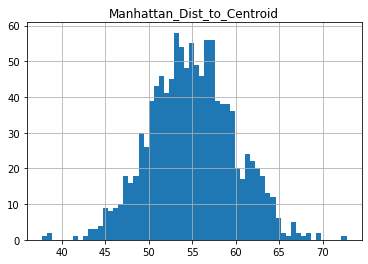

In [16]:
centroid_dist_hcp = PCA_All[PCA_All["Dataset"]=="hcp"][["ID","Manhattan_Dist_to_Centroid"]]
centroid_dist_hcp = centroid_dist_hcp.rename(columns={'ID': 'IID'})
print(centroid_dist_hcp.head())
centroid_dist_hcp.hist(bins=60)

In [43]:
#centroid_dist_hcp.to_csv('/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Heritability/data/HCP_centroid_dist.csv', index=False)

**Comment varie l'AUC en utilisant seulement les 18 premières dimensions ?**

In [17]:
X_pca = pca.transform(X=scl_bdd_hcp)
X_train_pca = pca.transform(X=X)

model = SVC(kernel='linear', probability=True,
            random_state=42,
            C=0.01, class_weight='balanced', decision_function_shape='ovr')

outputs = {}
val_pred = cross_val_predict(model, X_train_pca, y, cv=5)
auc = roc_auc_score(y, val_pred)
outputs['labels_pred'] = val_pred
outputs['auc'] = auc
outputs['balanced_accuracy_score'] = balanced_accuracy_score(y, val_pred)

print(f'auc_cv: {outputs["auc"]}')
print(f'balanced_accuracy_score_cv: {outputs["balanced_accuracy_score"]}')

model.fit(X_train_pca,y)

roc_auc_score(y,model.predict_proba(X_train_pca)[:,1]), balanced_accuracy_score(y, model.predict(X_train_pca))

auc_cv: 0.7718663156355127
balanced_accuracy_score_cv: 0.7718663156355126


(0.881782945736434, 0.7858527131782946)

**Quelle représentation ?**

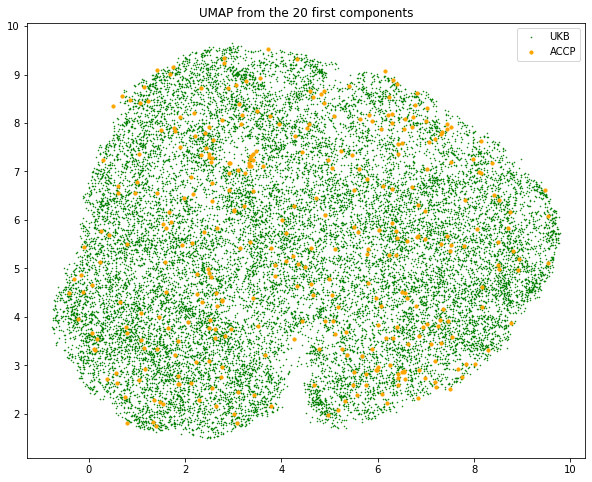

In [18]:
reducer_for_pca = umap.UMAP()#random_state=5)

ukb_pca = pca.transform(X=scl_bdd_ukb)
reducer_for_pca.fit(ukb_pca)
embedding2D_ukb_pca = reducer_for_pca.transform(ukb_pca)
embedding2D_troiani = reducer_for_pca.transform(X_train_pca)

plt.figure(figsize=(10,8))
plt.scatter(embedding2D_ukb_pca[:,0], embedding2D_ukb_pca[:,1], c='g', s=0.3, label='UKB')
plt.scatter(embedding2D_troiani[:,0], embedding2D_troiani[:,1], c='orange', s=10, label='ACCP')
plt.title('UMAP from the 20 first components')
plt.legend()
plt.show()

**Pour quelle valeur d'héritabilité ?**

In [18]:
df_HCP_PC = pd.DataFrame({"IID" : list(embeddings_HCP.index),
              "1stPC" : X_pca[:,0],
              "2dPC" : X_pca[:,1],
              "3dPC" : X_pca[:,2],
              "4thPC" : X_pca[:,3],
              "5thPC" : X_pca[:,4], 
              "6thPC" : X_pca[:,5], 
              "7thPC" : X_pca[:,6],
              "8thPC" : X_pca[:,7],
              "9thPC" : X_pca[:,8]})

df_HCP_PC.to_csv('/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Heritability/data/HCP_PCS.csv', index=False)
df_HCP_PC

,IID,1stPC,2dPC,3dPC,4thPC,5thPC,6thPC,7thPC,8thPC,9thPC
0,100206,7.942234,-3.062951,5.498870,-2.033602,2.109143,1.325941,3.310942,-0.776384,-3.617306
1,100307,5.278710,3.507138,6.787498,-1.265372,-0.467838,-2.212153,8.020516,-1.862365,-4.681076
2,100408,-7.307635,5.046183,-4.380279,0.744711,-0.876895,2.183338,2.287962,4.476512,-4.269872
3,100610,-1.678322,8.080242,-5.565412,-3.107843,2.935046,-5.179609,2.884158,-0.518757,1.933225
4,101006,8.234748,-4.577342,-3.945794,1.530383,0.210351,-1.107045,5.411723,2.710401,2.781415
...,...,...,...,...,...,...,...,...,...,...
1109,992774,7.784938,-5.255849,-6.284428,5.741702,1.239605,-3.305752,-2.471712,-3.933130,-0.384734
1110,993675,2.312372,-2.273474,7.487667,2.943923,6.725084,2.926827,4.169840,1.360843,4.318482
1111,994273,-1.300979,-1.844093,-4.604868,7.301063,-2.320126,6.738303,-2.901482,-2.491425,2.834198
1112,995174,6.465948,1.154570,7.492350,0.798125,-4.092558,-0.855804,2.804101,4.394065,-1.882303


#### SVC model, trained on the ACCP database

In [13]:
model = SVC(kernel='linear', probability=True,
            random_state=42,
            C=0.01, class_weight='balanced', decision_function_shape='ovr')

Specific stratification for a more relevant auc.

In [20]:
import os

strat_dic = {}
strat_path = '/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/'

for file in os.listdir(strat_path):
    if file.startswith('ACCpatterns_subjects_train_split'):
        strat_dic[f'train{file[-5:-4]}'] = pd.read_csv(f"{strat_path}{file}")
    if file.startswith('ACCpatterns_subjects_test_split'):
        strat_dic[f'test{file[-5:-4]}'] = pd.read_csv(f"{strat_path}{file}")

X_train = np.array([[]])
X_test = np.array([[]])
y_train = []
y_test = []

for key in strat_dic.keys():
    if key.startswith('train'):
        new_train_lines = ebdd_lbl_ACCP.loc[strat_dic[key][strat_dic[key].columns[0]]].drop('Left_PCS', axis=1).values
        X_train = np.vstack((X_train, new_train_lines)) if X_train.size else new_train_lines
        y_train += ebdd_lbl_ACCP.loc[strat_dic[key][strat_dic[key].columns[0]]]['Left_PCS'].to_list()
    
    if key.startswith('test'):
        new_test_lines = ebdd_lbl_ACCP.loc[strat_dic[key][strat_dic[key].columns[0]]].drop('Left_PCS', axis=1).values
        X_test = np.vstack((X_test, new_test_lines)) if X_test.size else new_test_lines
        y_test += ebdd_lbl_ACCP.loc[strat_dic[key][strat_dic[key].columns[0]]]['Left_PCS'].to_list()

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
model.fit(X_train, y_train)
roc_auc_score(y_test,model.predict_proba(X_test)[:,1]), balanced_accuracy_score(y_test, model.predict(X_test))

/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


(0.8373015873015873, 0.7410714285714286)

Cross validation to have another auc (which is supposed to be worse than with the stratification) 

In [21]:
outputs = {}
val_pred = cross_val_predict(model, X, y, cv=5)
auc = roc_auc_score(y, val_pred)
outputs['labels_pred'] = val_pred
outputs['auc'] = auc
outputs['balanced_accuracy_score'] = balanced_accuracy_score(y, val_pred)

In [22]:
outputs['auc'], outputs['balanced_accuracy_score']

(0.7641143776510165, 0.7641143776510164)

he auc value below is not relevant because we are training the model on the whole set so as to test the model on the whole set.

In [14]:
model.fit(X,y)
roc_auc_score(y,model.predict_proba(X)[:,1]), balanced_accuracy_score(y, model.predict(X))

(0.8863536638876701, 0.8101140851250549)

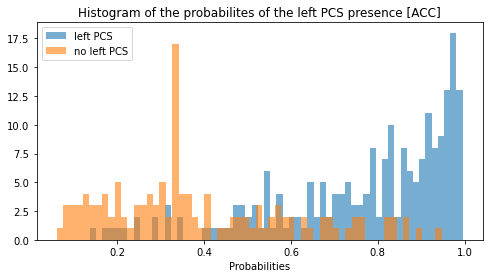

In [16]:
plt.figure(figsize=(8,4))
plt.hist(model.predict_proba(X)[y==1,1], bins=60, alpha=0.6, label='left PCS')
plt.hist(model.predict_proba(X)[y==0,1], bins=60, alpha=0.6, label='no left PCS')
plt.xlabel('Probabilities')
plt.title('Histogram of the probabilites of the left PCS presence [ACC]')
plt.legend()
plt.show()

In [17]:
float((model.predict(X) == (model.predict_proba(X)>0.5)[:,1]).sum())/len(X)

0.9032258064516129

#### Classification of the HCP embeddings

In [18]:
val_pred = model.predict(X=scl_bdd_hcp)

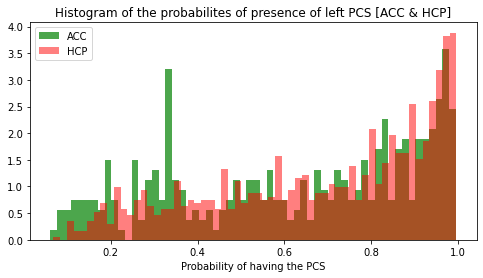

In [19]:
plt.figure(figsize=(8,4))
plt.hist(model.predict_proba(X)[:,1], bins=60, color='g', alpha=0.7, label='ACC', density=True)
plt.hist(model.predict_proba(scl_bdd_hcp)[:,1], bins=60, color='red', alpha=0.5, label='HCP', density=True)
plt.xlabel('Probability of having the PCS')
plt.title('Histogram of the probabilites of presence of left PCS [ACC & HCP]')
plt.legend()
plt.show()

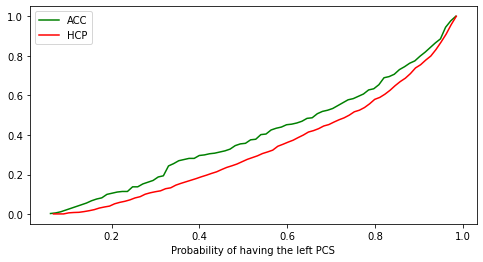

In [20]:
values_ACCP, base_ACCP = np.histogram(model.predict_proba(X)[:,1], bins=80)
cumulative_ACCP = np.cumsum(values_ACCP)
values_HCP, base_HCP = np.histogram(model.predict_proba(scl_bdd_hcp)[:,1], bins=80)
cumulative_HCP = np.cumsum(values_HCP)
plt.figure(figsize=(8,4))
plt.plot(base_ACCP[:-1], cumulative_ACCP/len(X), c='g', label='ACC')
plt.plot(base_HCP[:-1], cumulative_HCP/len(scl_bdd_hcp), c='r', label='HCP')
plt.xlabel('Probability of having the left PCS')
plt.legend()
plt.show()

#### SVM classification between ACCP and HCP datasets

In [21]:
scd_bdd_hcp = pd.DataFrame(scl_bdd_hcp, columns=embeddings_HCP.columns)
scd_bdd_hcp['Dataset'] = 0

scd_bdd_ACCP = pd.DataFrame(X,columns=embeddings_HCP.columns)
scd_bdd_ACCP['Dataset'] = 1

In [22]:
scd_bdd_HCP_ACCP = pd.concat([scd_bdd_hcp,scd_bdd_ACCP], axis=0)
scd_bdd_HCP_ACCP

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,...,dim246,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256,Dataset
0,0.430351,-0.020243,-0.772807,0.484776,-0.751663,-1.636484,0.968511,-0.366582,0.791657,-0.065783,-0.314999,0.186995,...,-0.148254,-0.447901,-0.727848,-1.307693,1.240760,-1.810208,-0.830390,0.422561,-1.212647,-0.099614,-0.178217,0
1,-0.369716,-0.472588,-1.045096,0.843269,-1.771047,-1.032357,-0.704230,0.222726,0.121407,1.003520,0.793591,0.470318,...,-1.264215,0.400385,-0.593897,-0.820767,2.087476,-2.086024,-1.185100,0.664112,-0.246290,1.481739,-1.759348,0
2,-0.667320,0.224860,-0.619985,2.142453,-2.176424,0.610571,-0.262829,1.046944,-0.835546,1.425300,-0.200088,-0.944962,...,-0.183528,0.995567,0.232447,-0.201876,-1.285214,0.063154,1.557980,-1.148278,1.806429,-0.186151,1.098351,0
3,0.304305,0.056121,-0.952062,0.082058,-1.027543,-0.181831,0.862581,2.618118,1.038001,0.499076,-0.094277,-1.492641,...,0.300983,0.263295,1.178269,0.596138,-0.232545,-0.468782,0.821631,-1.001450,-0.523867,0.513267,0.431558,0
4,-0.747531,-0.320569,-0.674616,-0.788419,1.646862,-0.013046,0.924201,-0.825682,0.602004,-0.400220,0.821956,-2.486791,...,0.772194,0.056951,0.913408,0.311425,-0.090093,0.055390,1.468358,1.103633,-0.274132,1.649838,-0.830607,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,-1.975197,-0.031147,2.395010,-0.056194,0.038204,1.689956,-2.553928,-0.250425,0.182960,0.340325,1.827683,-0.481254,...,-0.169187,0.999067,-0.399211,-1.782959,0.452047,1.647052,1.227758,0.335330,2.269309,0.666469,-1.974048,1
337,-1.055274,0.311682,0.648379,0.443670,0.684041,-1.693122,1.829300,1.481616,1.680886,-0.227772,0.862595,-1.956795,...,1.275276,1.561361,-0.021998,1.072222,-0.062672,1.345390,0.326711,-0.822830,-0.967832,0.355150,0.546172,1
338,0.232092,0.706098,-0.289988,0.549516,0.465432,-0.763222,1.227689,-1.144279,0.451805,-0.375314,0.123018,0.770166,...,-0.138436,-0.561103,-1.063533,-0.537652,-0.790907,-1.259251,0.146244,-0.070424,-0.372466,-0.456746,0.338811,1
339,0.784757,-0.922651,-1.322700,0.367079,-0.950231,1.218736,0.204536,-0.054044,1.031691,0.522902,2.060696,-0.438824,...,0.652990,-0.228987,-0.741358,-1.695785,0.584116,-0.067872,-0.482663,1.119466,-0.817388,-0.814147,-1.239067,1


In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(scd_bdd_HCP_ACCP.drop("Dataset", axis=1), scd_bdd_HCP_ACCP["Dataset"], test_size=0.01, random_state=40)

In [25]:
model2 = SVC(kernel='linear', probability=True,
            random_state=42,
            C=0.01, class_weight='balanced', decision_function_shape='ovr')

In [26]:
model2.fit(X_train,y_train)
val_predict = cross_val_predict(model2, X_train, y_train, cv=10)
auc = roc_auc_score(y_train, val_predict)
auc

0.7871397402821009

In [27]:
roc_auc_score(y_test, model2.predict_proba(X_test)[:,1])

1.0

### Classification of the UKB dataset

In [28]:
val_pred = model.predict(X=scl_bdd_ukb)

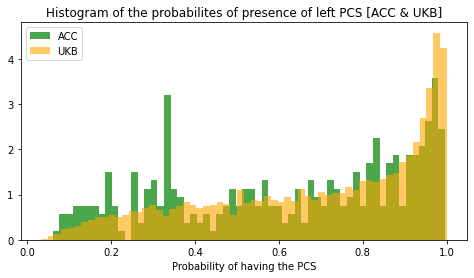

In [29]:
plt.figure(figsize=(8,4))
plt.hist(model.predict_proba(X)[:,1], bins=60, color='g', alpha=0.7, label='ACC', density=True)
plt.hist(model.predict_proba(scl_bdd_ukb)[:,1], bins=60, color='orange', alpha=0.6, label='UKB', density=True)
plt.xlabel('Probability of having the PCS')
plt.title('Histogram of the probabilites of presence of left PCS [ACC & UKB]')
plt.legend()
plt.show()

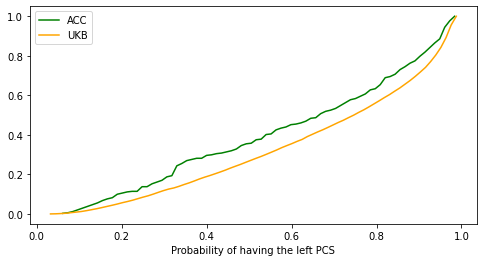

In [30]:
values_ACCP, base_ACCP = np.histogram(model.predict_proba(X)[:,1], bins=80)
cumulative_ACCP = np.cumsum(values_ACCP)
values_UKB, base_UKB = np.histogram(model.predict_proba(scl_bdd_ukb)[:,1], bins=80)
cumulative_UKB = np.cumsum(values_UKB)
plt.figure(figsize=(8,4))
plt.plot(base_ACCP[:-1], cumulative_ACCP/len(X), c='g', label='ACC')
plt.plot(base_UKB[:-1], cumulative_UKB/len(scl_bdd_ukb), c='orange', label='UKB')
plt.xlabel('Probability of having the left PCS')
plt.legend()
plt.show()

In [54]:
ACC_pred = pd.DataFrame({"IID" : list(embeddings_ACCP.ID),
              "Left_Binary_Pred" : model.predict_proba(X)[:,1]})

print(ACC_pred.sort_values(by='Left_Binary_Pred').iloc[0:9])
print()
print(list(ACC_pred.sort_values(by='Left_Binary_Pred').iloc[0:9].IID))
print()
print(ACC_pred.sort_values(by='Left_Binary_Pred').iloc[-9:])
print()
print(list(ACC_pred.sort_values(by='Left_Binary_Pred').iloc[-9:].IID))

                                  IID  Left_Binary_Pred
80                  e0065_anat_t1_s03          0.061031
102                  nih_chp_00756_t1          0.078140
297  sub-active04_ses-pretraining_T1w          0.088685
230                  nih_chp_04910_t1          0.089182
125                  nih_chp_01579_t1          0.098610
164                  nih_chp_03812_t1          0.101782
295  sub-active01_ses-pretraining_T1w          0.102358
170                  nih_chp_03881_t1          0.110380
240                  nih_chp_05068_t1          0.112731

['e0065_anat_t1_s03', 'nih_chp_00756_t1', 'sub-active04_ses-pretraining_T1w', 'nih_chp_04910_t1', 'nih_chp_01579_t1', 'nih_chp_03812_t1', 'sub-active01_ses-pretraining_T1w', 'nih_chp_03881_t1', 'nih_chp_05068_t1']

                                      IID  Left_Binary_Pred
135                      nih_chp_02221_t1          0.983890
142                      nih_chp_02677_t1          0.985068
222                      nih_chp_04815_t1   

In [55]:
HCP_pred = pd.DataFrame({"IID" : list(embeddings_HCP.index),
              "Left_Binary_Pred" : model.predict_proba(scl_bdd_hcp)[:,1]})

print(HCP_pred.sort_values(by='Left_Binary_Pred').iloc[0:9])
print()
print(list(HCP_pred.sort_values(by='Left_Binary_Pred').iloc[0:9].IID))
print()
print(HCP_pred.sort_values(by='Left_Binary_Pred').iloc[-9:])
print()
print(list(HCP_pred.sort_values(by='Left_Binary_Pred').iloc[-9:].IID))

         IID  Left_Binary_Pred
742   461743          0.067706
735   448347          0.102681
428   183741          0.105387
393   176441          0.107944
917   700634          0.109685
1086  955465          0.110329
361   171330          0.113384
533   206727          0.118041
528   205725          0.121040

[461743, 448347, 183741, 176441, 700634, 955465, 171330, 206727, 205725]

         IID  Left_Binary_Pred
422   182032          0.992746
890   665254          0.992864
625   287248          0.993247
139   127933          0.993846
974   783462          0.994355
1080  942658          0.994512
538   207628          0.994595
1076  930449          0.996349
1090  962058          0.996642

[182032, 665254, 287248, 127933, 783462, 942658, 207628, 930449, 962058]


In [51]:
UKB_pred = pd.DataFrame({"IID" : list(embeddings_UKB.index),
              "Left_Binary_Pred" : model.predict_proba(scl_bdd_ukb)[:,1]})

print(UKB_pred.sort_values(by='Left_Binary_Pred').iloc[0:9])
print()
print(list(UKB_pred.sort_values(by='Left_Binary_Pred').iloc[0:9].IID))
print()
print(UKB_pred.sort_values(by='Left_Binary_Pred').iloc[-9:])
print()
print(list(UKB_pred.sort_values(by='Left_Binary_Pred').iloc[-9:].IID))

               IID  Left_Binary_Pred
8209   sub-2946274          0.032252
15942  sub-4805237          0.035552
12395  sub-3950911          0.042655
4183   sub-1992714          0.047500
4866   sub-2155455          0.048298
13566  sub-4238734          0.048907
2279   sub-1530148          0.049013
13020  sub-4105360          0.050615
12195  sub-3900134          0.052050

['sub-2946274', 'sub-4805237', 'sub-3950911', 'sub-1992714', 'sub-2155455', 'sub-4238734', 'sub-1530148', 'sub-4105360', 'sub-3900134']

               IID  Left_Binary_Pred
17779  sub-5251360          0.997365
9488   sub-3254023          0.997378
4868   sub-2156372          0.997388
7150   sub-2702817          0.997394
7353   sub-2747702          0.997411
8813   sub-3093845          0.999982
4545   sub-2080471          0.999985
2085   sub-1487836          0.999986
19730  sub-5722883          0.999990

['sub-5251360', 'sub-3254023', 'sub-2156372', 'sub-2702817', 'sub-2747702', 'sub-3093845', 'sub-2080471', 'sub-1487836', 

In [43]:
UKB_pred["IID"] = UKB_pred["IID"].apply(lambda x: x[4:])
UKB_pred

,IID,Left_Binary_Pred
0,1000021,1
1,1000458,0
2,1000575,0
3,1000606,1
4,1000963,0
...,...,...
21046,6023469,1
21047,6023808,1
21048,6023847,1
21049,6024038,1


In [44]:
#UKB_pred.to_csv('/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Heritability/data/UKB_left_binary_pred.csv', index=False)

### Visualization (UMAP)

We fit the reducer only on the UKB database (which is the largest), we concatenate the three bases and reduce them together.

In [56]:
scd_bdd_ACCP = pd.DataFrame(X,columns=embeddings_HCP.columns)

scd_bdd_hcp = pd.DataFrame(scl_bdd_hcp, columns=embeddings_HCP.columns)

scd_bdd_UKB = pd.DataFrame(scl_bdd_ukb, columns=embeddings_HCP.columns)


In [57]:
reducer = umap.UMAP()

reducer.fit(scd_bdd_UKB)

embedding2D_ACCP = reducer.transform(X)
embedding2D_HCP = reducer.transform(scl_bdd_hcp)
embedding2D_UKB = reducer.transform(scl_bdd_ukb)
                                    
embedding2D_ACCP = pd.DataFrame(embedding2D_ACCP,columns=['Dim 1', 'Dim 2'])
embedding2D_HCP = pd.DataFrame(embedding2D_HCP, columns=['Dim 1', 'Dim 2'])
embedding2D_UKB = pd.DataFrame(embedding2D_UKB, columns=['Dim 1', 'Dim 2'])



/casa/home/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [61]:
embedding2D_ACCP['Left_PCS'] = y.values
embedding2D_ACCP['Dataset'] = 'ACC'
embedding2D_ACCP['Prediction'] = model.predict(X)
embedding2D_ACCP['Pred_proba'] = model.predict_proba(X)[:,1]
embedding2D_ACCP['ID'] = ebdd_lbl_ACCP.index


embedding2D_HCP['Left_PCS'] = -1
embedding2D_HCP['Dataset'] = 'HCP'
embedding2D_HCP['Prediction'] = model.predict(scl_bdd_hcp)
embedding2D_HCP['Pred_proba'] = model.predict_proba(scl_bdd_hcp)[:,1]
embedding2D_HCP['ID'] = embeddings_HCP.index


embedding2D_UKB['Left_PCS'] = -1
embedding2D_UKB['Dataset'] = 'UKB'
embedding2D_UKB['Prediction'] = model.predict(scl_bdd_ukb)
embedding2D_UKB['Pred_proba'] = model.predict_proba(scl_bdd_ukb)[:,1]
embedding2D_UKB['ID'] = embeddings_UKB.index

HCP_and_ACCP_2D = pd.concat([embedding2D_ACCP, embedding2D_HCP], axis=0)
HCP_ACCP_UKB_2D = pd.concat([HCP_and_ACCP_2D, embedding2D_UKB], axis=0)

In [62]:
HCP_ACCP_UKB_2D.head()

,Dim 1,Dim 2,Left_PCS,Dataset,Prediction,Pred_proba,ID
0,3.385392,1.569015,0,ACC,0,0.176919,1-03HUBJO_t0
1,3.575241,3.471120,1,ACC,1,0.791712,1-08ANDTI_t0
2,1.573749,3.084852,1,ACC,0,0.282177,1-11LEBJO_t0
3,5.026573,6.898385,1,ACC,1,0.675969,1-15LEHMI_t0
4,5.365532,5.370947,1,ACC,1,0.982223,1-17COLMA_t0


### For 3D visualisation

In [47]:
reducer3D = umap.UMAP(n_components=3)

reducer3D.fit(scd_bdd_UKB)

embedding3D_ACCP = reducer3D.transform(X)
embedding3D_HCP = reducer3D.transform(scl_bdd_hcp)
embedding3D_UKB = reducer3D.transform(scl_bdd_ukb)
                                    
embedding3D_ACCP = pd.DataFrame(embedding3D_ACCP,columns=['Dim 1', 'Dim 2', 'Dim 3'])
embedding3D_HCP = pd.DataFrame(embedding3D_HCP, columns=['Dim 1', 'Dim 2', 'Dim 3'])
embedding3D_UKB = pd.DataFrame(embedding3D_UKB, columns=['Dim 1', 'Dim 2', 'Dim 3'])

In [48]:
embedding3D_ACCP['Left_PCS'] = y.values
embedding3D_ACCP['Dataset'] = 'ACC'
embedding3D_ACCP['Prediction'] = model.predict(X)
embedding3D_ACCP['Pred_proba'] = model.predict_proba(X)[:,1]
embedding3D_ACCP['ID'] = ebdd_lbl_ACCP.index


embedding3D_HCP['Left_PCS'] = -1
embedding3D_HCP['Dataset'] = 'HCP'
embedding3D_HCP['Prediction'] = model.predict(scl_bdd_hcp)
embedding3D_HCP['Pred_proba'] = model.predict_proba(scl_bdd_hcp)[:,1]
embedding3D_HCP['ID'] = embeddings_HCP.index


embedding3D_UKB['Left_PCS'] = -1
embedding3D_UKB['Dataset'] = 'UKB'
embedding3D_UKB['Prediction'] = model.predict(scl_bdd_ukb)
embedding3D_UKB['Pred_proba'] = model.predict_proba(scl_bdd_ukb)[:,1]
embedding3D_UKB['ID'] = embeddings_UKB.index

HCP_and_ACCP_3D = pd.concat([embedding3D_ACCP, embedding3D_HCP], axis=0)
HCP_ACCP_UKB_3D = pd.concat([HCP_and_ACCP_3D, embedding3D_UKB], axis=0)

In [49]:
print(len(embedding3D_ACCP), len(ebdd_lbl_ACCP.index))
print(len(embedding3D_HCP), len(embeddings_HCP.index))
print(len(embedding3D_UKB), len(embeddings_UKB.index))

341 341
1114 1114
21051 21051


In [65]:
HCP_and_ACCP_3D['Prediction'] = HCP_and_ACCP_3D['Prediction'].astype(str)
HCP_ACCP_UKB_3D['Prediction'] = HCP_ACCP_UKB_3D['Prediction'].astype(str)
HCP_ACCP_UKB_3D.head()

,Dim 1,Dim 2,Dim 3,Left_PCS,Dataset,Prediction,Pred_proba,ID
0,3.443465,3.313781,5.597828,0,ACCP,0,0.196307,1-03HUBJO_t0
1,3.056240,3.244252,3.328516,1,ACCP,1,0.797900,1-08ANDTI_t0
2,3.441321,5.335814,5.005774,1,ACCP,0,0.251095,1-11LEBJO_t0
3,4.946717,5.615586,5.430983,1,ACCP,1,0.774663,1-15LEHMI_t0
4,5.405264,6.249068,2.819029,1,ACCP,1,0.976432,1-17COLMA_t0


In [62]:
HCP_ACCP_UKB_3D.isna().sum(axis=0)

Dim 1         0
Dim 2         0
Dim 3         0
Left_PCS      0
Dataset       0
Prediction    0
Pred_proba    0
ID            0
dtype: int64

In [52]:
# https://plotly.com/python/pca-visualization/

import plotly.express as px

fig = px.scatter_3d(
    HCP_and_ACCP_3D, x='Dim 1', y='Dim 2', z='Dim 3', 
    color='Dataset',
    title=f'3D UMAP Dataset_HCP_ACCP',
    labels={'0': 'dim 1', '1': 'dim 2', '2': 'dim 3'},
    text='ID',
    opacity=0.7,
)
fig.update_traces(mode = 'markers')
fig.write_html("html_plot/Left_PCS_Dataset_HCP_ACCP.html")
fig.show()

In [66]:
fig = px.scatter_3d(
    HCP_and_ACCP_3D, x='Dim 1', y='Dim 2', z='Dim 3',
    color='Prediction',
    title=f'3D UMAP Prediction on HCP ACC',
    labels={'0': 'dim 1', '1': 'dim 2', '2': 'dim 3'},
    text='ID',
    opacity=0.7,
)
fig.update_traces(mode = 'markers')
fig.write_html("html_plot/Left_PCS_Prediction_HCP_ACCP.html")
fig.show()

In [55]:
fig = px.scatter_3d(
    HCP_and_ACCP_3D, x='Dim 1', y='Dim 2', z='Dim 3',
    color='Pred_proba',
    title=f'3D UMAP Proba prediction on HCP ACC',
    labels={'0': 'dim 1', '1': 'dim 2', '2': 'dim 3'},
    text='ID',
    opacity=0.7,
)
fig.update_traces(mode = 'markers')
fig.write_html("html_plot/Left_PCS_Proba_prediction_HCP_ACCP.html")

This first figure is made to observe the site effect between UKB, ACCP and HCP databases. 

In [63]:
def plot_UMAP(dataset, title, hue):

    ebb2D_dataset = dataset[['Dim 1', 'Dim 2']]
    unique_values = np.sort(dataset[hue].unique())

    if type(dataset[hue].iloc[0])==type("str"):
        unique_colors = [sns.color_palette()[i] for i in range(len(unique_values))]
        dataset_colors = [sns.color_palette()[0] if x == 'HCP'\
                          else sns.color_palette()[1] if x == 'ACC' \
                          else sns.color_palette()[2] for x in dataset['Dataset']]
        s = [8 if x == 'HCP'\
            else 8 if x == 'ACC' \
            else 0.3 for x in dataset['Dataset']]
    elif -1 in unique_values :
        unique_values[:-1], unique_values[-1] = unique_values[1:], unique_values[0] 
        unique_colors = [sns.color_palette()[i] for i in range(len(unique_values))]
        dataset_colors = [sns.color_palette()[x] if x!=-1 else sns.color_palette()[len(unique_values)-1] for x in dataset[hue]]
        s = 10
    else :
        unique_colors = [sns.color_palette()[i] for i in range(len(unique_values))]
        dataset_colors = [sns.color_palette()[x] for x in dataset[hue]]
        s = 20

    plt.figure(figsize=(12,8))
    plt.scatter(
        ebb2D_dataset.iloc[:, 0],
        ebb2D_dataset.iloc[:, 1],
        s=s,
        c=dataset_colors)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(title, fontsize=12)
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor=unique_colors[i], markersize=10, 
                                label=f'{unique_values[i]}') 
                    for i in range(len(unique_values))]
    plt.legend(handles=legend_handles, title=hue, loc='best')
    plt.show()

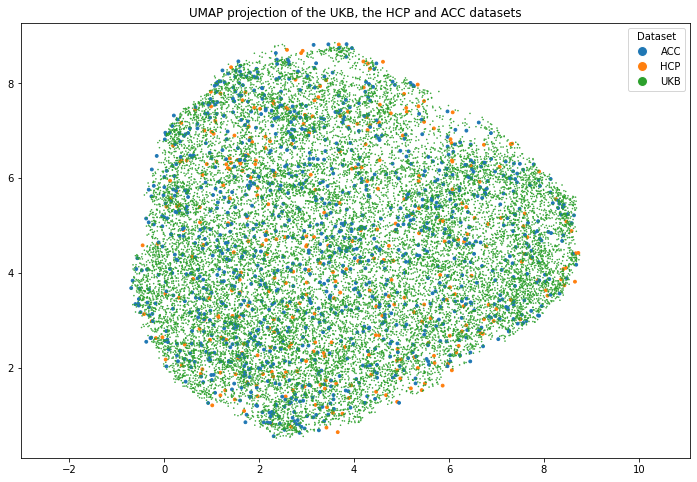

In [64]:
plot_UMAP(HCP_ACCP_UKB_2D, 'UMAP projection of the UKB, the HCP and ACC datasets', 'Dataset')

The second figure is made to point out the position of the people having the paracingular (1) (from the ACCP database), those who don't have it (0) (from the ACCP database), and those we don't know (-1) (from the HCP database).

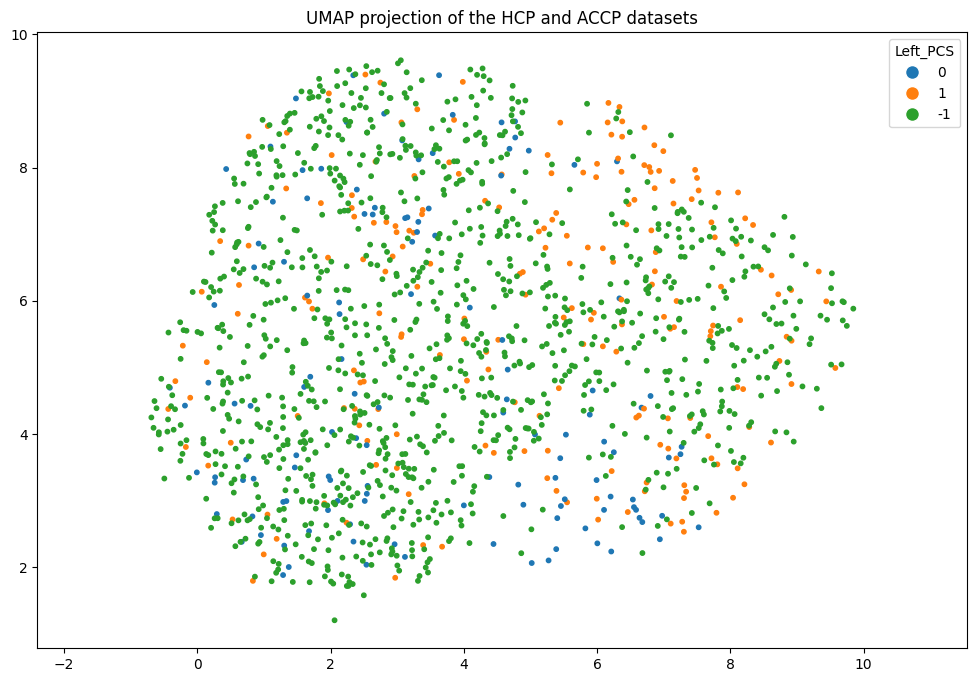

In [58]:
plot_UMAP(HCP_and_ACCP_2D, 'UMAP projection of the HCP and ACCP datasets', 'Left_PCS')

Then, the following figure highlights the two classes in the ACCP database.

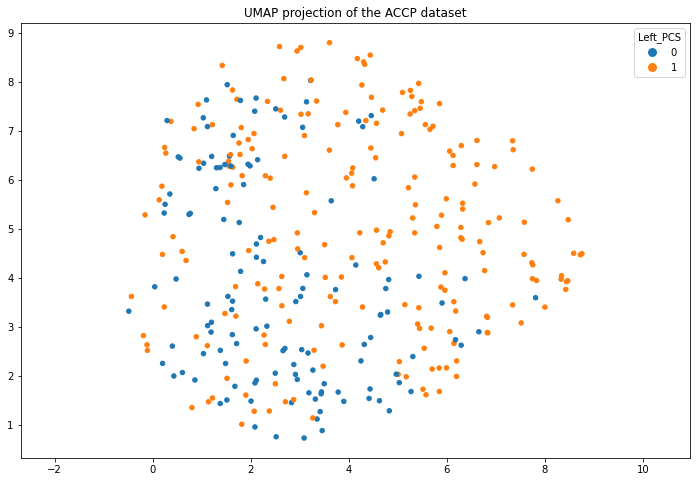

In [68]:
embedding2D_ACCP = reducer.transform(scd_bdd_ACCP)
embedding2D_ACCP = pd.DataFrame(embedding2D_ACCP,columns=['Dim 1', 'Dim 2'])
embedding2D_ACCP['Left_PCS'] = y.values
embedding2D_ACCP['Dataset'] = 'ACC'
embedding2D_ACCP['Prediction'] = model.predict(X)
embedding2D_ACCP['Pred_proba'] = model.predict_proba(X)[:,1]
embedding2D_ACCP['ID'] = ebdd_lbl_ACCP.index
plot_UMAP(embedding2D_ACCP, 'UMAP projection of the ACCP dataset', 'Left_PCS')

Let's see the SVC borders on the UMAP

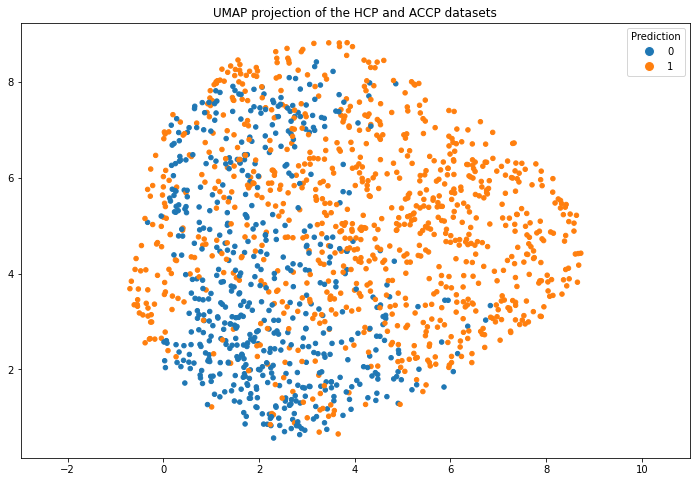

In [70]:
plot_UMAP(HCP_and_ACCP_2D, 'UMAP projection of the HCP and ACCP datasets', 'Prediction')

### CSV file generation for SOLAR

In [ ]:
df_HCP_binary_pred_PCS = pd.DataFrame({"IID" : list(embeddings_HCP.index),
              "Pred" : model.predict(X=scl_bdd_hcp)})

#df_HCP_binary_pred_PCS.to_csv('/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Heritability/data/HCP_binary_pred_left_PCS_2.csv', index=False)
df_HCP_binary_pred_PCS.sort_values('IID')

,IID,Pred
0,100206,0
1,100307,1
2,100408,0
3,100610,0
4,101006,0
...,...,...
1109,992774,0
1110,993675,1
1111,994273,0
1112,995174,0


In [ ]:
df_HCP_prob_pred_PCS = pd.DataFrame({"IID" : list(embeddings_HCP.index),
              "Pred" : model.predict_proba(scl_bdd_hcp)[:,1]})

#df_HCP_prob_pred_PCS.to_csv('/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Heritability/data/HCP_prob_pred_left_PCS_2.csv', index=False)
df_HCP_prob_pred_PCS

,IID,Pred
0,100206,0.328975
1,100307,0.705047
2,100408,0.600544
3,100610,0.416104
4,101006,0.258237
...,...,...
1109,992774,0.537250
1110,993675,0.707631
1111,994273,0.343621
1112,995174,0.584266


### To compare the prediction obtained from different embeddings models (dim256)

In [ ]:
left_PCS_pred2_dim256 = pd.read_csv('/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Heritability/data/HCP_prob_pred_left_PCS_2.csv')
left_PCS_pred_dim256 = pd.read_csv('/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Heritability/data/HCP_prob_pred_left_PCS.csv')
LeftPCS = pd.merge(left_PCS_pred_dim256, left_PCS_pred2_dim256, how='inner', on='IID', suffixes=[2561,2562])
LeftPCS.drop('IID', axis=1).corr()

,Pred2561,Pred2562
Pred2561,1.000000,0.949155
Pred2562,0.949155,1.000000


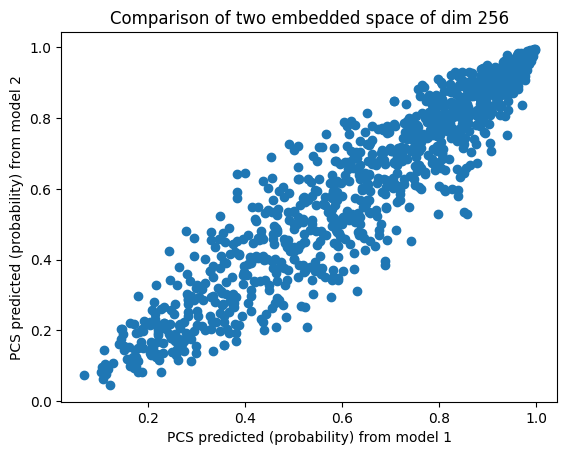

In [ ]:
plt.scatter(LeftPCS['Pred2561'], LeftPCS['Pred2562'])
plt.xlabel('PCS predicted (probability) from model 1')
plt.ylabel('PCS predicted (probability) from model 2')
plt.title('Comparison of two embedded space of dim 256')
plt.show()

In [ ]:
left_PCS_pred_dim2561 = pd.read_csv('/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Heritability/data/HCP_binary_pred_left_PCS.csv')
left_PCS_pred_dim2562 = pd.read_csv('/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Heritability/data/HCP_binary_pred_left_PCS_2.csv')

In [ ]:
(left_PCS_pred_dim2561['Pred'] == left_PCS_pred_dim2562['Pred']).sum()/len(left_PCS_pred_dim2561)

0.9111310592459605